In [1]:
import train as train
import generate
import eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyro

In [2]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "sinus-(10,20)-normaldelta"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-10k ======


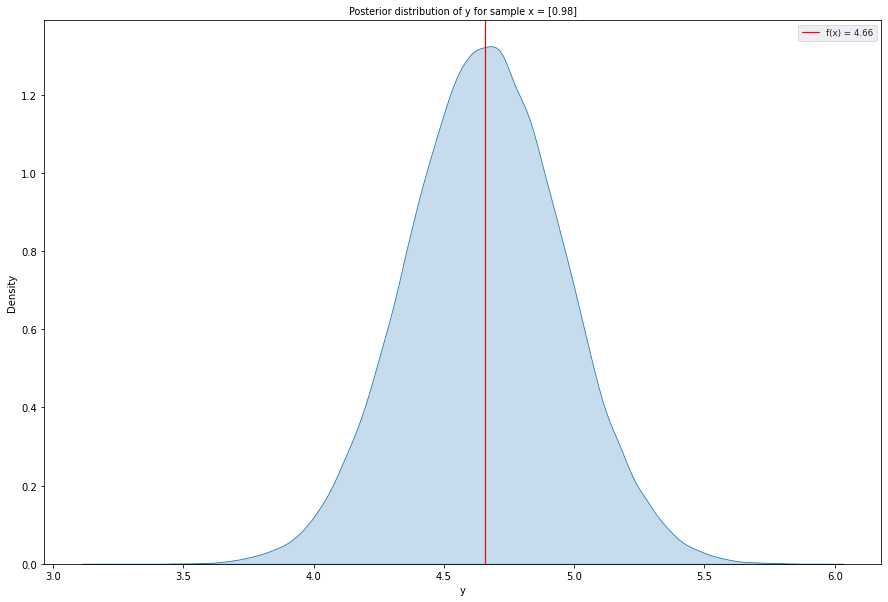

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

In [6]:
x_test[0], y_test[0]

(tensor([-6.9470]), tensor(1.8078))

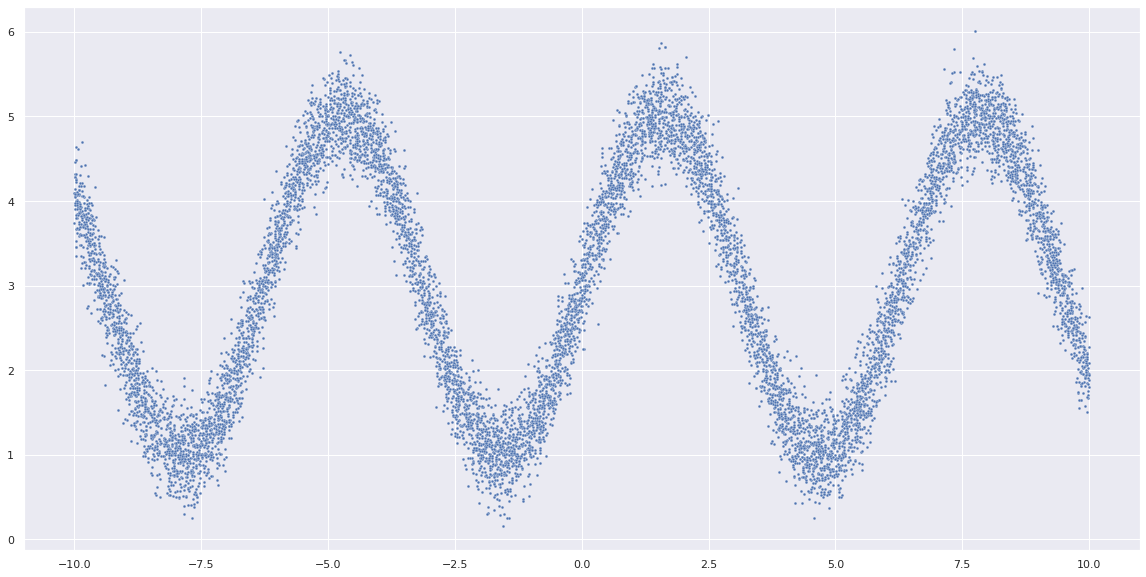

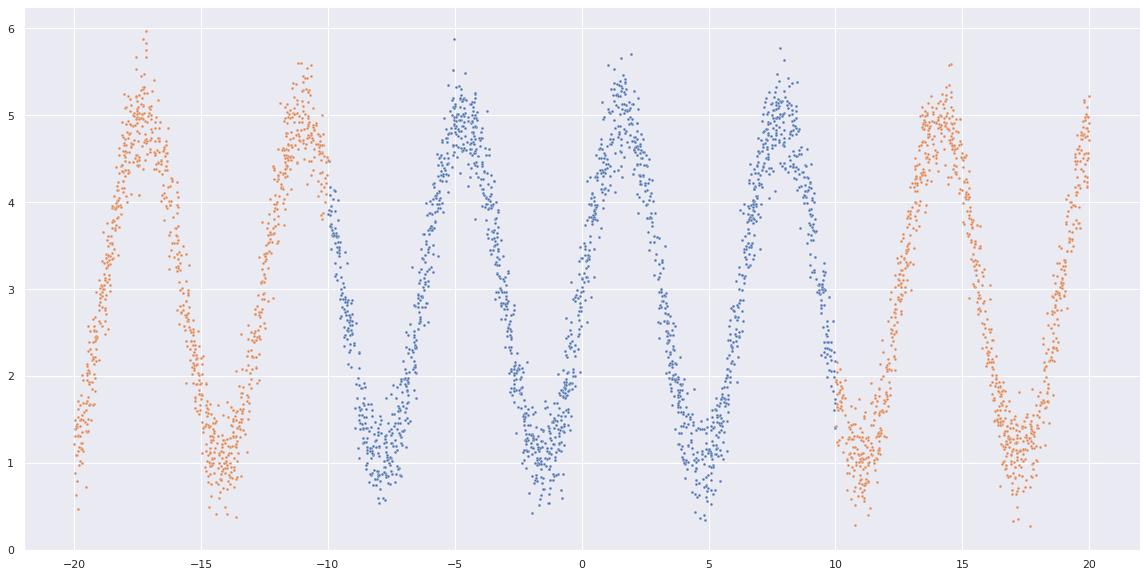

In [7]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train, s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test_in_domain.flatten(), y=y_test_in_domain, s=8, ax=ax)
sns.scatterplot(x=x_test_out_domain.flatten(), y=y_test_out_domain, s=8, ax=ax)
plt.show()


In [8]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    infer_model = train.train(config, dataset_config, f"{BASE_DIR}")

AutoGuideList(
  (0): AutoNormal()
  (1): AutoDelta()
)
Using device: cpu
===== Training profile sinus-(10,20)-normaldelta =====


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Training finished in 0:14:08.125903 seconds


In [2]:
#inference_model = eval.load_model(BASE_DIR, config)
inference_model = infer_model

NameError: name 'infer_model' is not defined

In [10]:
predictive = inference_model.get_predictive(num_predictions=500)
train_samples = predictive(x_train)
train_samples.keys()
test_samples = predictive(x_test)


In [1]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

train_pred_summary = summary(train_samples)
test_pred_summary = summary(test_samples)

NameError: name 'train_samples' is not defined

In [12]:
train_y = train_pred_summary["obs"]
train_mu = train_pred_summary["_RETURN"]
train_predictions = pd.DataFrame({
    "x": x_train.flatten(),
    "mu": train_mu["mean"].flatten(),
    "mu_5": train_mu["5%"].flatten(),
    "mu_95": train_mu["95%"].flatten(),
    "y_mean": train_y["mean"].flatten(),
    "y_5": train_y["5%"].flatten(),
    "y_95": train_y["95%"].flatten(),
    "true_y": y_train.flatten()
})

test_y = test_pred_summary["obs"]
test_mu = test_pred_summary["_RETURN"]
test_predictions = pd.DataFrame({
    "x": x_test.flatten(),
    "mu": test_mu["mean"].flatten(),
    "mu_5": test_mu["5%"].flatten(),
    "mu_95": test_mu["95%"].flatten(),
    "y_mean": test_y["mean"].flatten(),
    "y_5": test_y["5%"].flatten(),
    "y_95": test_y["95%"].flatten(),
    "true_y": y_test.flatten()
})


In [13]:
train_predictions.head()

,x,mu,mu_5,mu_95,y_mean,y_5,y_95,true_y
0,0.976270,2.586498,2.284687,2.912782,2.578725,0.991964,4.097123,4.439082
1,4.303787,2.886418,2.460369,3.355542,2.841713,1.214247,4.365119,1.333688
2,2.055268,2.671665,2.344510,3.039898,2.687834,1.202530,4.149179,4.639153
3,0.897664,2.581160,2.280020,2.908207,2.577726,1.016116,4.060650,4.532379
4,-1.526904,2.513756,2.217658,2.833764,2.540907,0.915684,4.046678,0.305544


In [14]:
train_pred_sorted = train_predictions.sort_values(by='x')
test_pred_sorted = test_predictions.sort_values(by='x')

def plot_predictions(summary, SAVE_PATH=None):
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['mu'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['mu_5'], y2=summary['mu_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)
    
    sns.set(rc = {'figure.figsize':(25,12)})
    fig, ax = plt.subplots()

    ax.set_title("Posterior predictive distribution with 95% CI")
    sns.lineplot(x=summary['x'], y=summary['y_mean'], ax=ax, color='red')
    ax.fill_between(x=summary['x'], y1=summary['y_5'], y2=summary['y_95'], alpha=0.3, color='green')
    sns.scatterplot(x=summary['x'], y=summary['true_y'], ax=ax, alpha=0.7, size=0.5, legend=False)

    if SAVE_PATH:
        plt.savefig(SAVE_PATH)

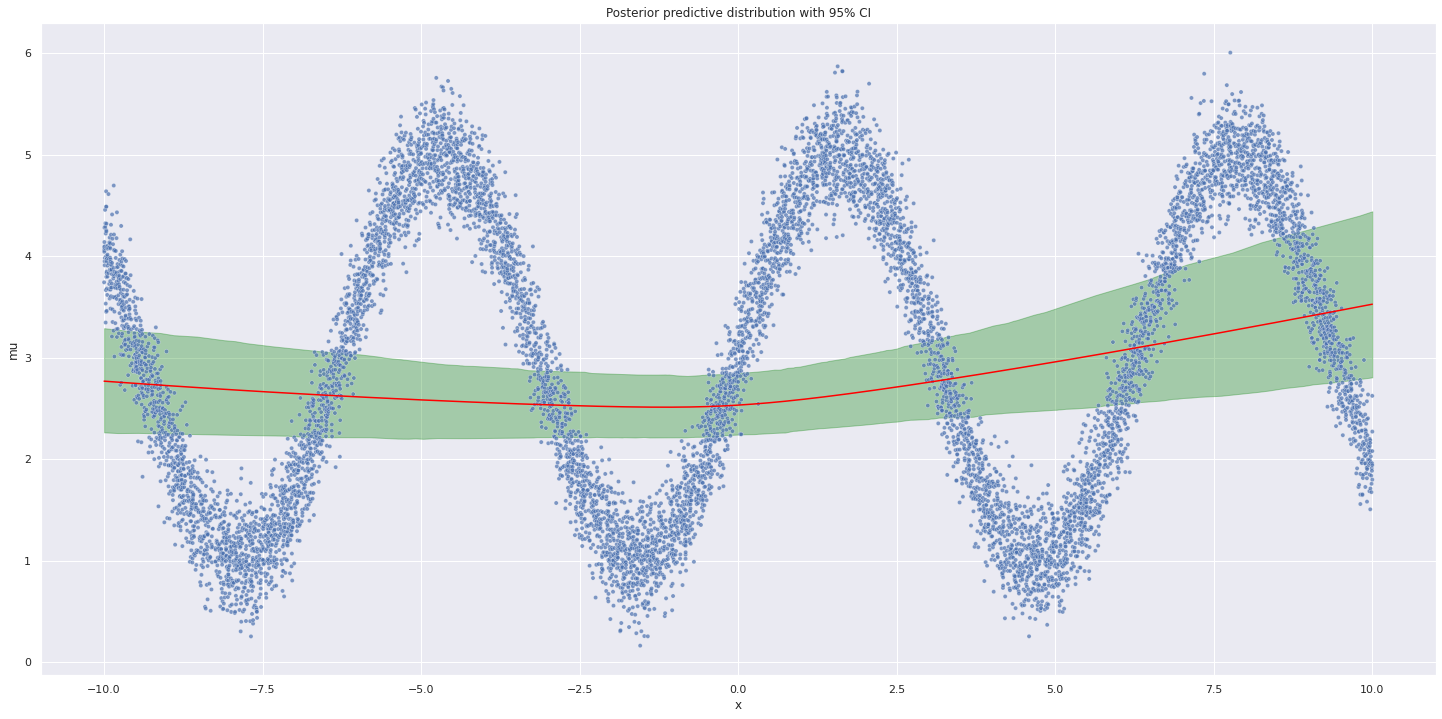

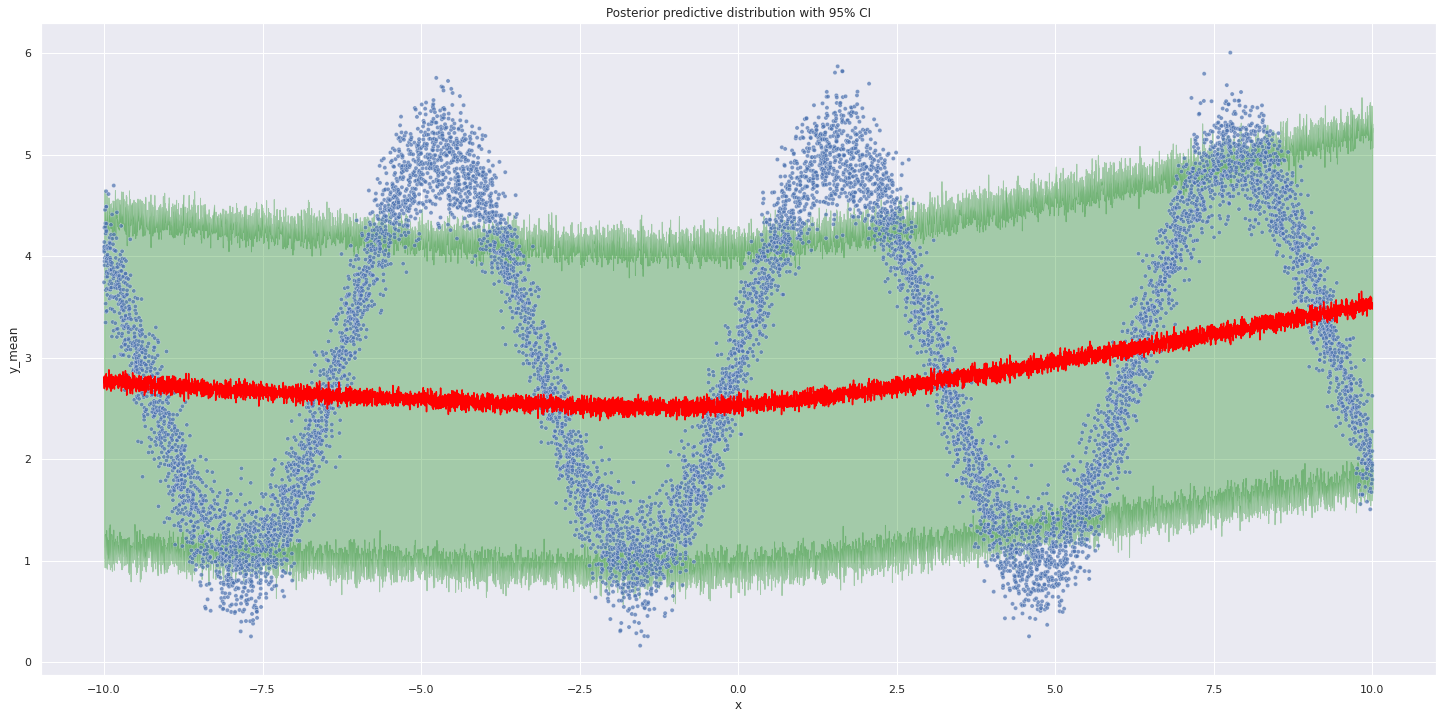

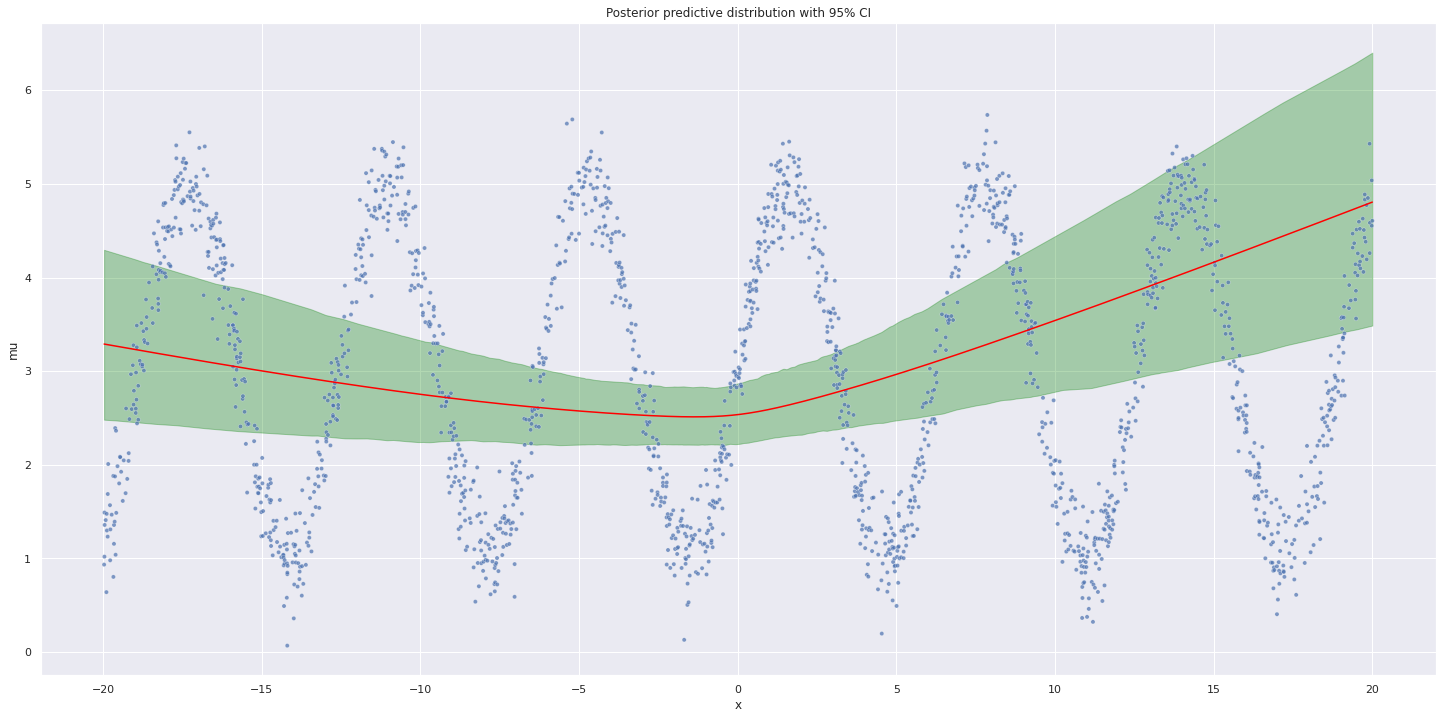

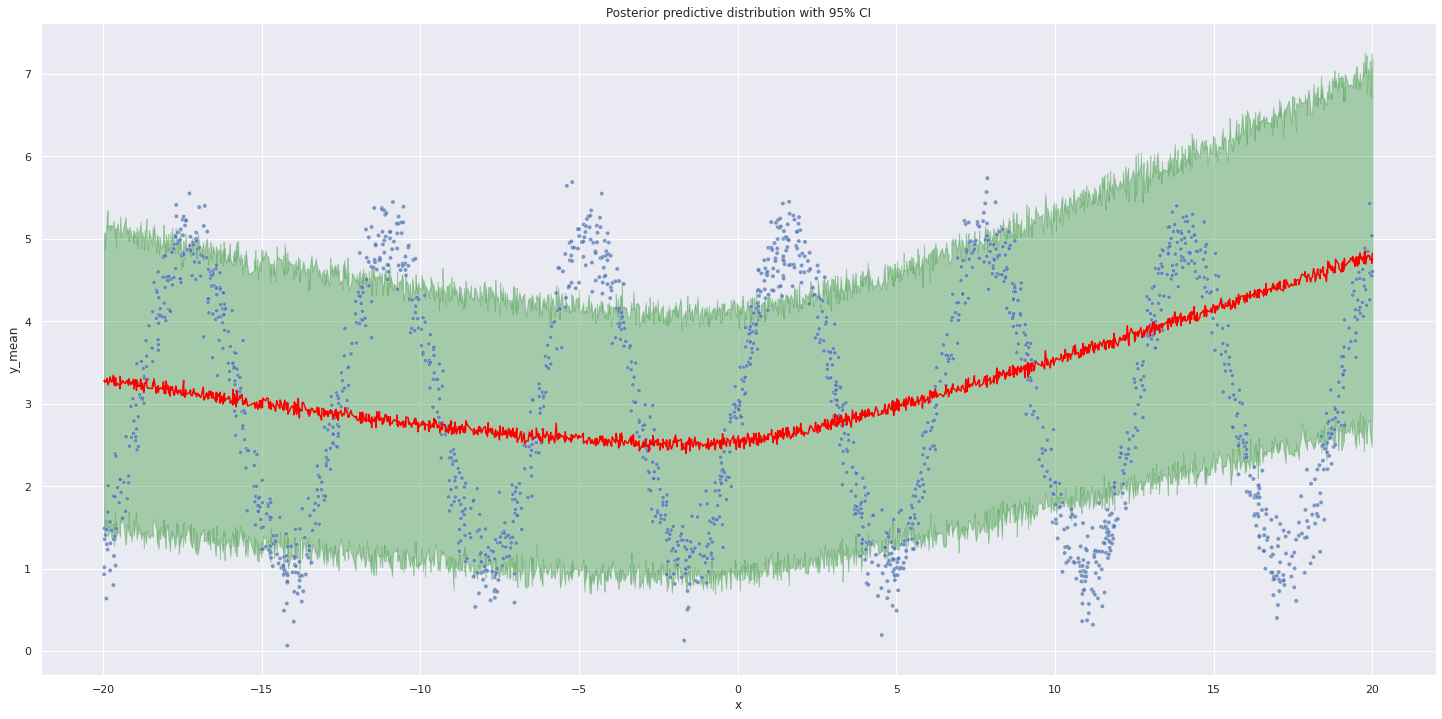

In [15]:
plot_predictions(train_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_train_predictions.png")
plot_predictions(test_pred_sorted, SAVE_PATH=f"{BASE_DIR}/1d_test_predictions.png")

using device: cpu
====== evaluating profile sinus-(10,20)-normaldelta ======


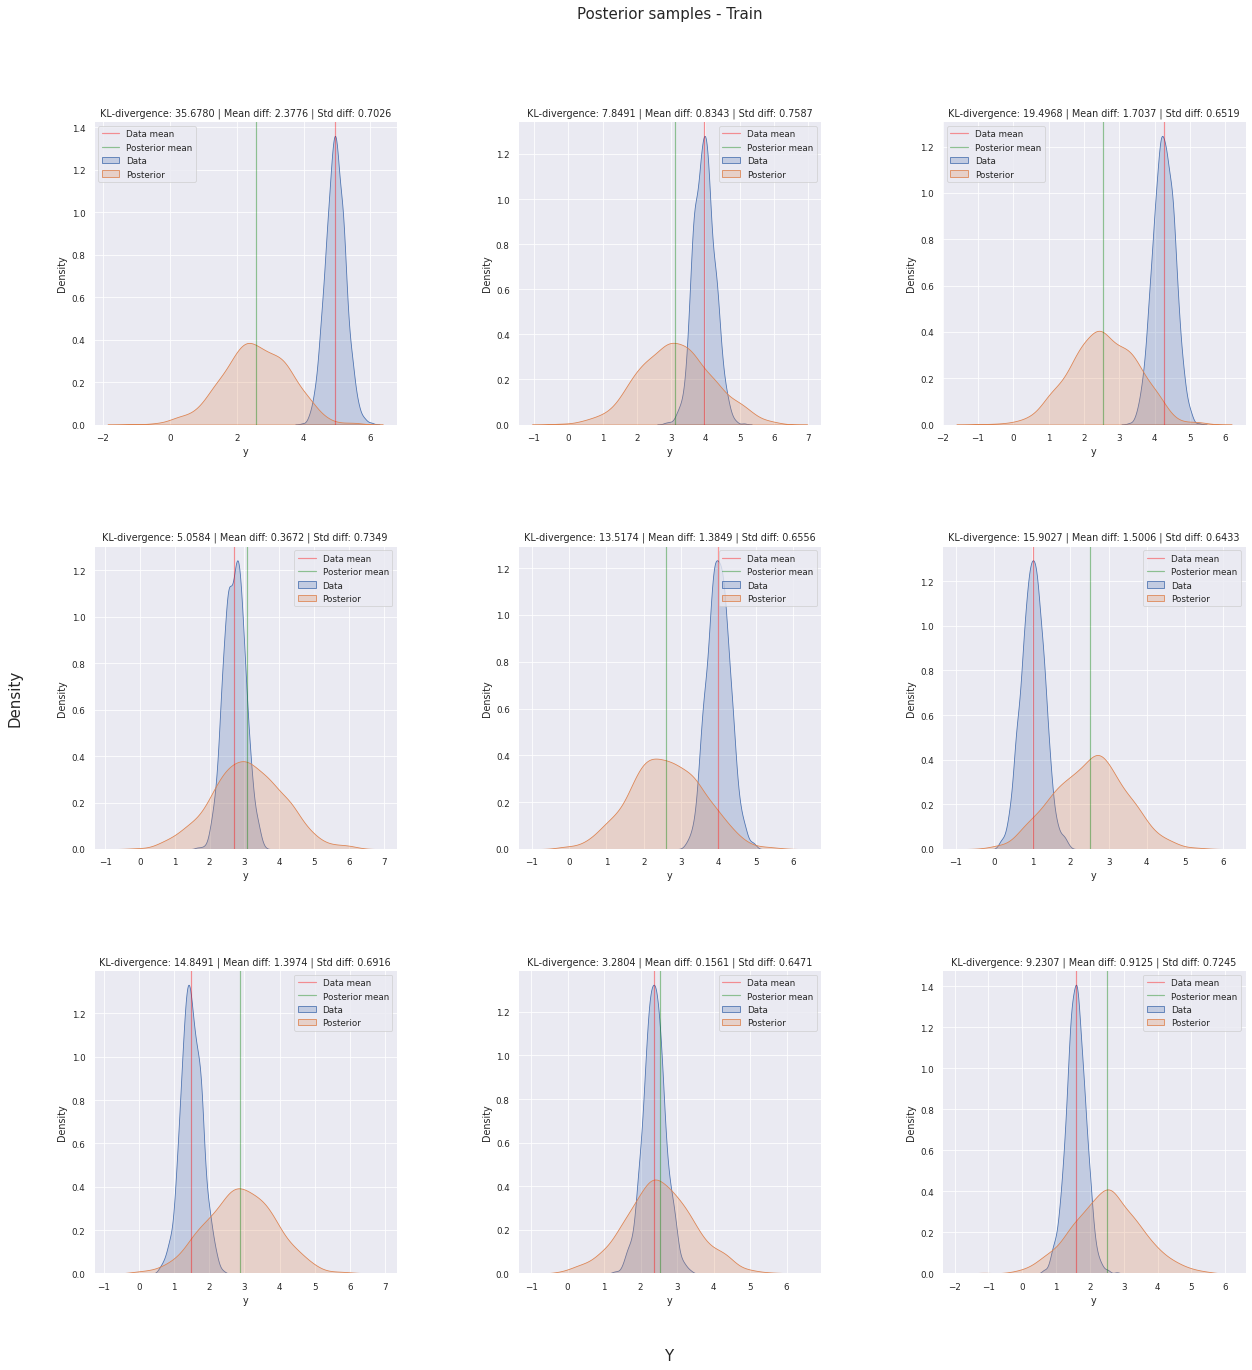

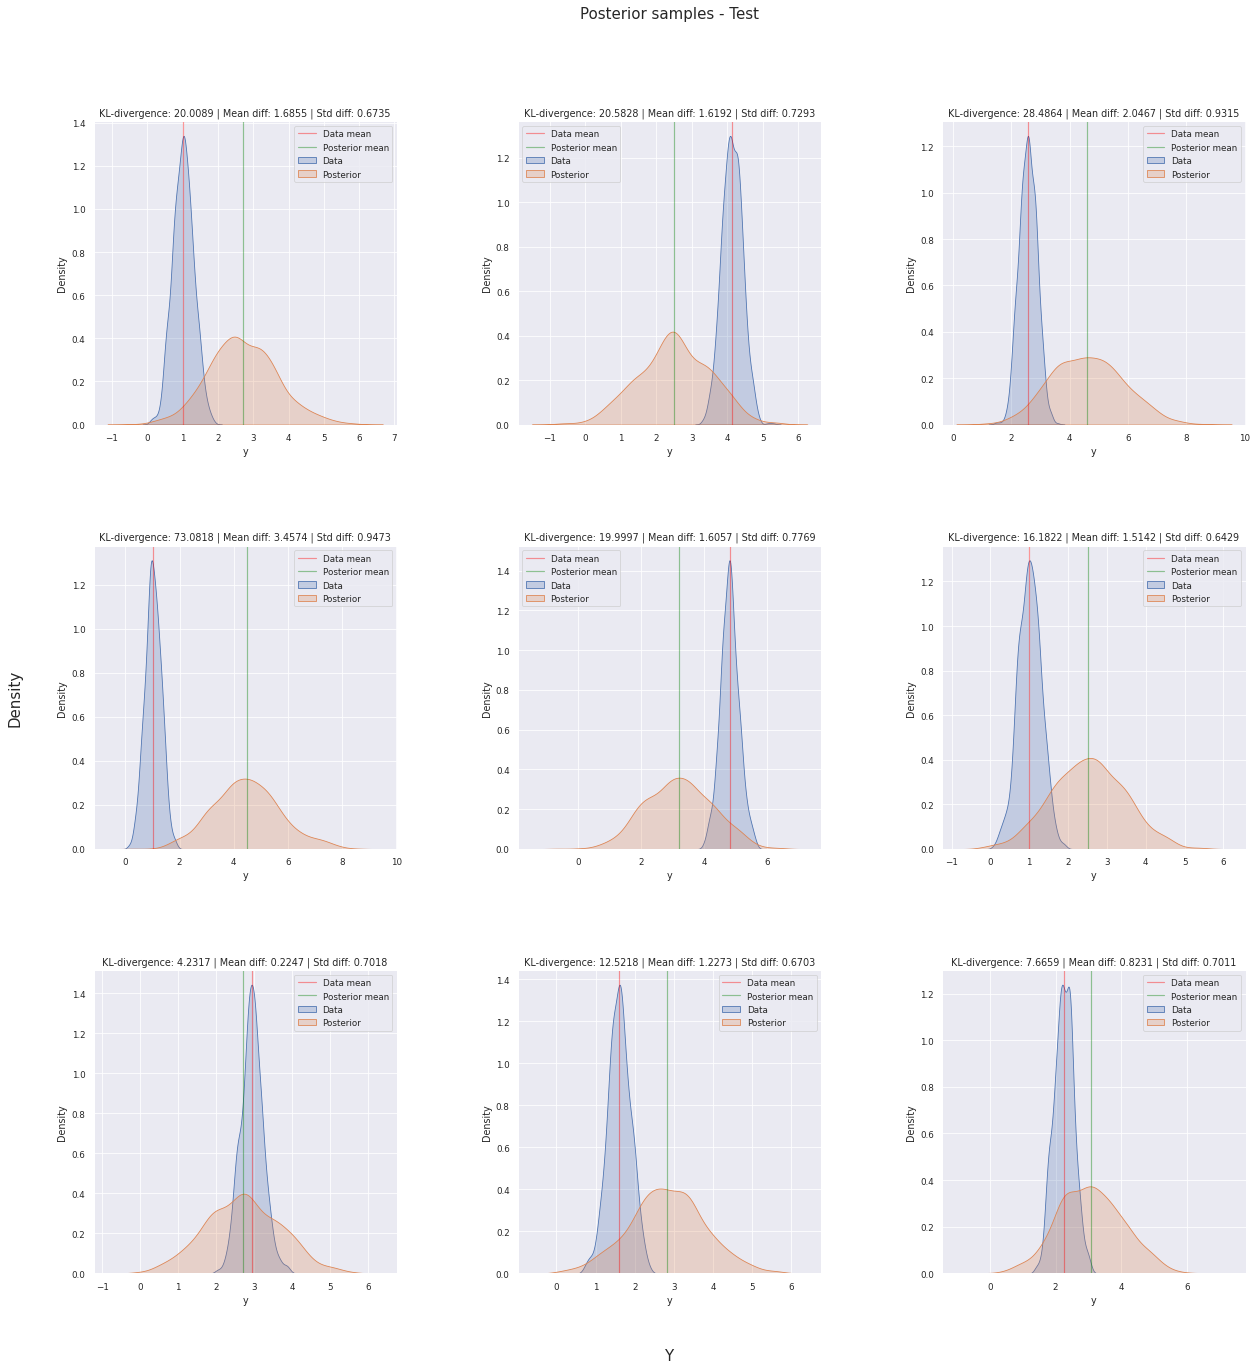

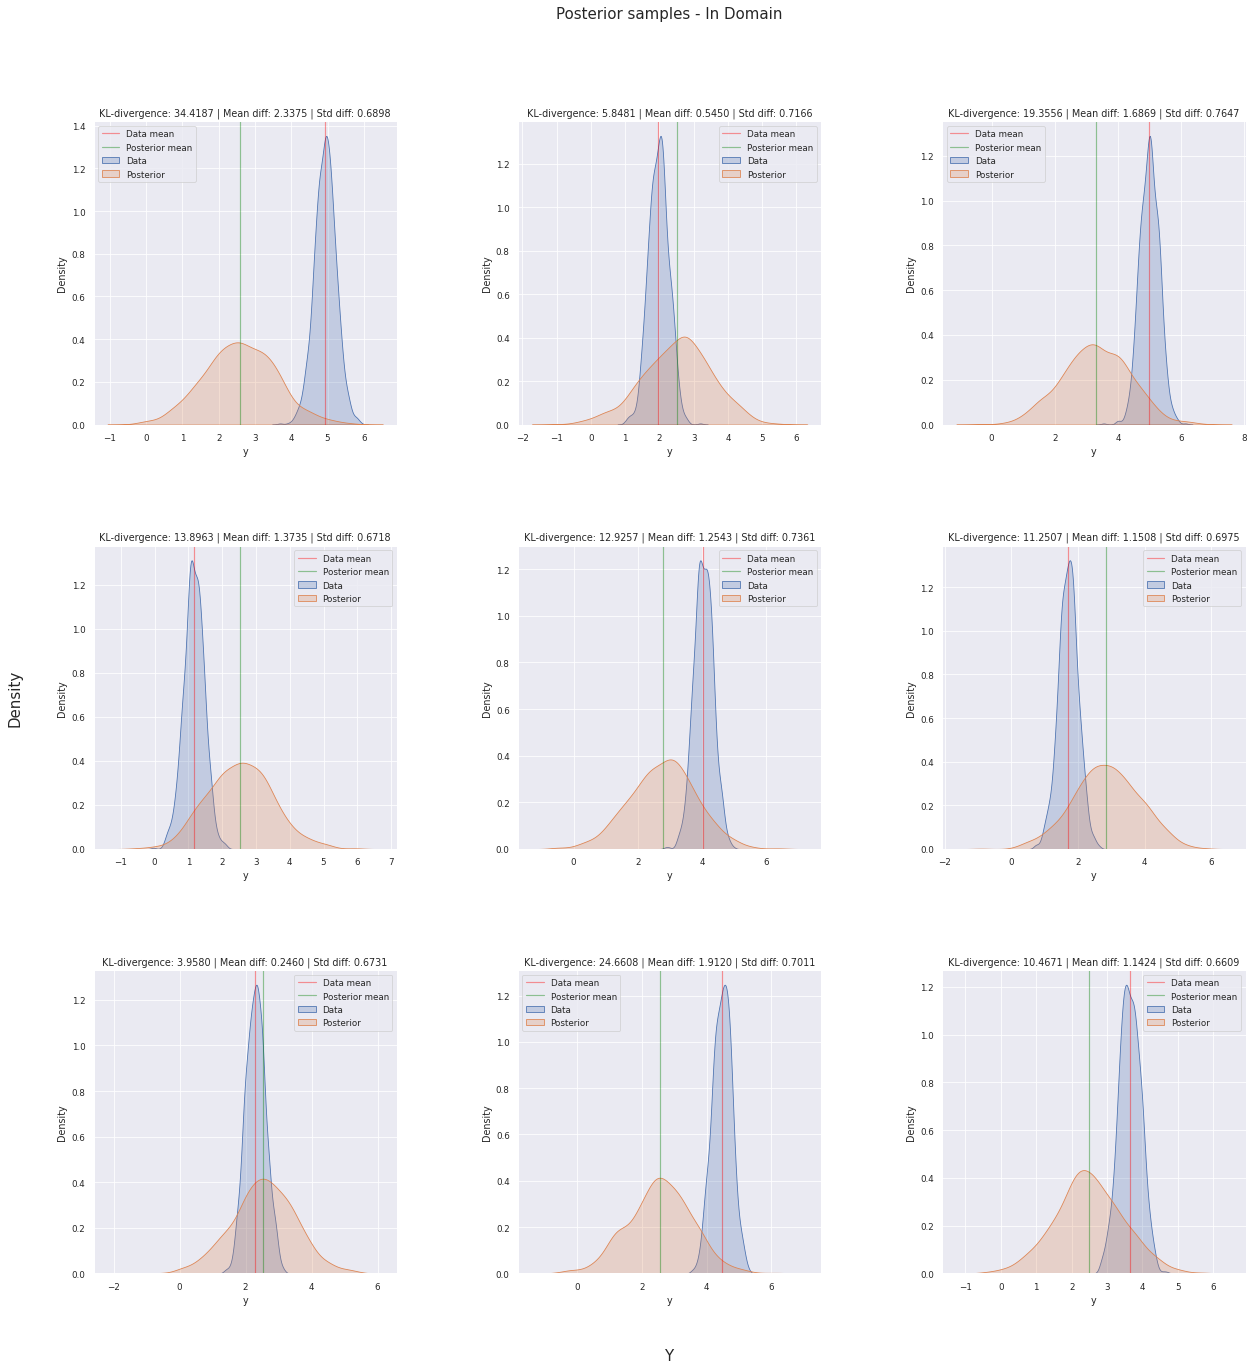

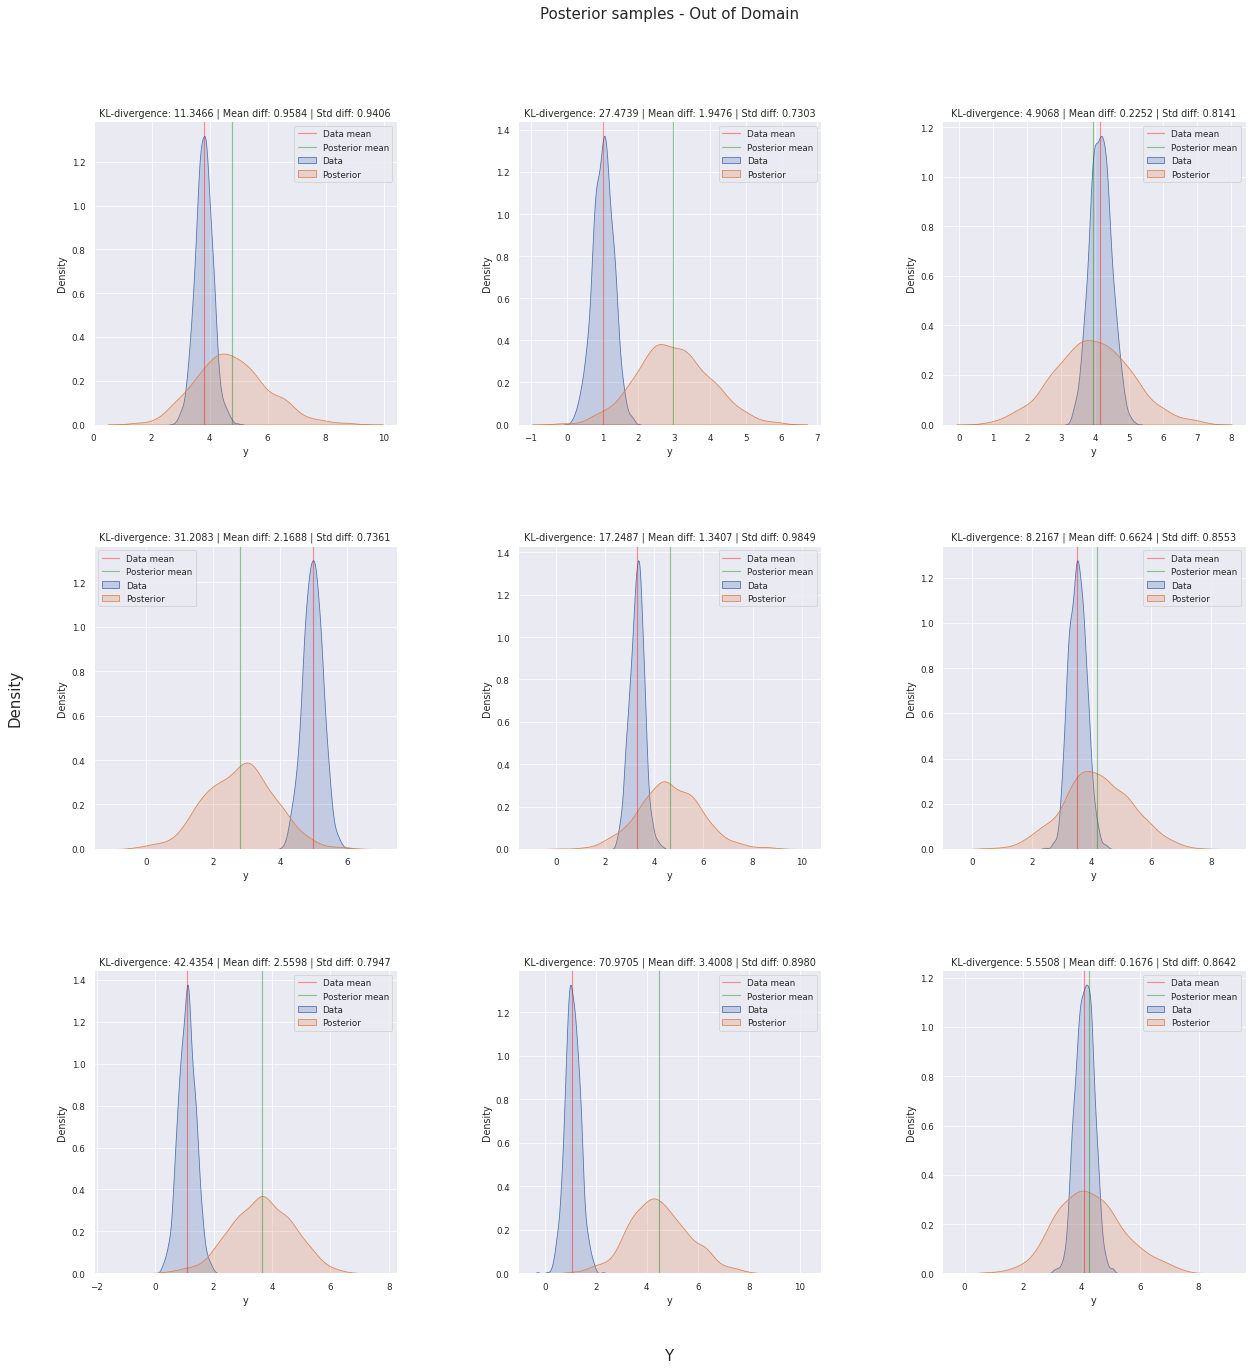

Eval done in 0:00:23.186967


In [16]:
if True:
            if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")

            eval.eval(config, dataset_config, f"{BASE_DIR}", inference_model=inference_model)

In [17]:
inference_model.guide

AutoGuideList(
  (0): AutoNormal(
    (locs): PyroModule(
      (fc0): PyroModule()
      (fc1): PyroModule()
      (fc2): PyroModule()
    )
    (scales): PyroModule(
      (fc0): PyroModule()
      (fc1): PyroModule()
      (fc2): PyroModule()
    )
  )
  (1): AutoDelta()
)

In [18]:
pyro.get_param_store().keys()

dict_keys(['AutoGuideList.0.locs.fc0.weight', 'AutoGuideList.0.scales.fc0.weight', 'AutoGuideList.0.locs.fc0.bias', 'AutoGuideList.0.scales.fc0.bias', 'AutoGuideList.0.locs.fc1.weight', 'AutoGuideList.0.scales.fc1.weight', 'AutoGuideList.0.locs.fc1.bias', 'AutoGuideList.0.scales.fc1.bias', 'AutoGuideList.0.locs.fc2.weight', 'AutoGuideList.0.scales.fc2.weight', 'AutoGuideList.0.locs.fc2.bias', 'AutoGuideList.0.scales.fc2.bias', 'AutoGuideList.1.sigma'])

In [19]:
pyro.get_param_store()["AutoDelta.fc1.weight"]

KeyError: 'AutoDelta.fc1.weight'

In [ ]:
inference_model.guide

AutoDelta(
  (fc0): PyroModule()
  (fc1): PyroModule()
  (fc2): PyroModule()
)

In [ ]:
x_test[0], y_test[0]

(tensor([-6.9470]), tensor(1.8078))